<a href="https://colab.research.google.com/github/omararh/Expression-editor-assistant/blob/main/correct_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Load data
import json

def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    return json.load(f)

INPUT_DATA_BASE_PATH = 'input_data/'

AVAILABLE_CONTEXT = read_file(INPUT_DATA_BASE_PATH + 'context.json')

SYMFONY_EXAMPLES = read_file(INPUT_DATA_BASE_PATH + 'examples.json')

# NLP :

Cette partie va nous servir pour vérifier a quel point les réponses de l'API sont valide (précision), et de filtrer l'ensemble des exemples ...

In [ ]:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
!python -m spacy download fr_core_news_md

# Load french tokenizer, tagger, parser
nlp = spacy.load('fr_core_news_md')

def get_embedding(text):
    """
    Get normalized average embedding of all tokens (filtered).
    """
    doc = nlp(text)
    vectors = np.array([token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct])

    if len(vectors) == 0:
        return np.zeros((nlp.vocab.vectors_length,))

    avg_vector = np.mean(vectors, axis=0)
    return avg_vector / np.linalg.norm(avg_vector)


def filter_by_embedding(input, dict, top_k=5):
    """
    return K relevant examples from the examples list
    Args:
        input: user request
        dict: (description -> key) examples
        top_k: K relevant examples to be returned

    Returns:
        K relevant examples
    """
    input_embedding = get_embedding(input)

    similarities = []

    for description, key in dict.items():
        desc_embedding = get_embedding(description)

        similarity = cosine_similarity([input_embedding], [desc_embedding])[0][0]
        similarities.append((similarity, description, key))

    similarities.sort(reverse=True)
    top_examples = [(desc, expr) for _, desc, expr in similarities[:top_k]]

    return top_examples


def calculate_similarity(expected, generated):
    """

    """
    # Vérifier l'égalité exacte
    if expected == generated or expected.strip() == generated.strip():
        return 1.0

    # Similarité par embedding
    expected_embedding = get_embedding(expected)
    generated_embedding = get_embedding(generated)

    # Fallback si problème d'embedding
    if not expected_embedding.any() or not generated_embedding.any():
        expected_words = set(expected.split())
        generated_words = set(generated.split())
        return len(expected_words.intersection(generated_words)) / len(expected_words) if expected_words else 0.0

    return min(float(cosine_similarity([expected_embedding], [generated_embedding])[0][0]), 1.0) # Garantir que la valeur est entre 0 et 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 21.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Embedding test

# API call
ici on a un ensemble de fonctions qui vont nous servir a un préparer le
prompt puis faire la call API et en suite extraire la réponse.

In [10]:
import requests
from google.colab import userdata

# Configuration de l'API
API_URL = "https://api.mistral.ai/v1/chat/completions"
API_KEY = userdata.get('API_KEY')

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

def generate_expression(user_intent, available_context=None, examples=None):
    prompt = _build_prompt(user_intent, available_context, examples)

    try:
        return _generate_with_api(prompt)
    except Exception as e:
        print(f"Erreur: {e}")
        return ""

def _build_prompt(user_intent, available_context=None, examples=None):
    """Construit un prompt clair et minimaliste pour le modèle"""
    prompt = (
        "Tu es un assistant expert en Symfony Expression Language. "
        "Ta tâche est de générer une **seule** expression Symfony valide, sans aucune explication, "
        "en te basant uniquement sur le contexte et les exemples fournis.\n\n"
    )

    # Contexte disponible
    if available_context:
        prompt += "Contexte :\n"
        for category, items in available_context.items():
            if isinstance(items, dict):
                prompt += f"- {category} :\n"
                for key, value in items.items():
                    prompt += f"  * {key}: {value}\n"
            else:
                prompt += f"- {category} : {', '.join(items)}\n"
        prompt += "\n"

    # Exemples pertinents
    if examples:
        prompt += "Exemples :\n"
        for description, expression in examples.items():
            prompt += f"Demande : {description}\n"
            prompt += f"Expression : {expression}\n\n"

    # Ajout de l'intention actuelle de l'utilisateur
    prompt += f"Demande : {user_intent.strip()}\n"
    prompt += "Expression :"

    return prompt

def _generate_with_api(prompt):
    payload = {
        "model": "mistral-large-latest",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.1,
        "max_tokens": 100
    }

    response = requests.post(API_URL, headers=headers, json=payload)

    if response.status_code == 200:
        result = response.json()
        response_content = result["choices"][0]["message"]["content"]
        return _extract_response(response_content)
    else:
        raise Exception(f"Erreur API: {response.status_code} - {response.text}")

def _extract_response(response_content):
    """Extrait la partie pertinente de la réponse"""
    # Recherche spécifiquement l'expression après "Expression :"
    if "Expression :" in response_content:
        # Extrait tout ce qui suit le dernier "Expression :"
        parts = response_content.split("Expression :")
        response_content = parts[-1].strip()

    # Supprime tout ce qui pourrait suivre l'expression (comme "Demande :")
    if "Demande :" in response_content:
        response_content = response_content.split("Demande :")[0].strip()

    # Supprime les guillemets s'ils sont présents
    response_content = response_content.strip('"\'')

    # Supprime les lignes supplémentaires s'il y en a
    if "\n" in response_content:
        response_content = response_content.split("\n")[0].strip()

    return response_content

# First prompt

In [ ]:
user_question = "Pour chaque ligne, retourner false si 'key_response' est égal à 'LIST_OUI_NON_NON' ou si 'key_response' est null, sinon retourner true"

##### Filtred examples
examples = {v: k for k, v in SYMFONY_EXAMPLES.items()}
filtred_examples = filter_by_embedding(user_question, examples, top_k=10)
print(filtred_examples)


#### Filtred context
context = {v: k for k, v in AVAILABLE_CONTEXT.items()}
filtred_context = filter_by_embedding(user_question, context, top_k=5)
print(filtred_context)
expression = generate_expression(
    user_question,
    available_context=filtred_context,
    examples=filtred_examples
)
print(f"Expression générée: {expression}")

[('Exécuter le modèle X et retourner Y si le résultat est undefined ou null', "getModelValue('X') || Y"), ('Vérifier si X est null', 'isNull(X)'), ('Vérifier si X est défini (non null)', 'X != null'), ('Pour chaque ligne, vérifier si la valeur de la colonne X est égale à Y', 'row.X == Y'), ("Construire un chemin complet en concaténant le chemin de base et l'ID de l'élément courant", "legacyContext.contextVar.basePath ~ '/' ~ legacyContext.contextVar.currentItemId"), ('Vérifier si la fonction A ou la fonction B retourne vrai', 'functionA() or functionB()'), ("Vérifier si le résultat d'une fonction appliquée aux résultats de X et Y est inférieur ou égal à Z", 'function(X(), Y()) <= Z'), ('Vérifier si le résultat de la fonction A est supérieur au résultat de la fonction B', 'functionA() > functionB()'), ('Vérifier si X est strictement égal à Y (même type)', 'X === Y'), ('Pour chaque ligne, vérifier si le montant est entre 0 et 1000', 'row.amount > 0 and row.amount <= 1000')]
[('Fonction u

AttributeError: 'list' object has no attribute 'items'

# Test

Pour évaluer la précision et la performance des API de modèles de langage (LLM), nous n'utilisons pas un systéme par EPOCHs (avec plusieurs exécutions suivies d'une moyenne des résultats), car les appels aux API peuvent être influencés par un mécanisme de cache.
Cela signifie que répéter plusieurs fois la même requête peut donner des réponses plus rapides (grâce au cache), ce qui fausserait les mesures de performance réelles. Par conséquent, nous préférons analyser les résultats à partir d'une seule exécution par requête afin d’obtenir une évaluation plus représentative des conditions d'utilisation réelles.

### Précision

Époque 1/1...
Erreur: Erreur API: 429 - {"message":"Requests rate limit exceeded"}
Erreur: Erreur API: 429 - {"message":"Requests rate limit exceeded"}
Erreur: Erreur API: 429 - {"message":"Requests rate limit exceeded"}
Erreur: Erreur API: 429 - {"message":"Requests rate limit exceeded"}
Précision: 91.67%
Époque terminée en 18.80s

Temps total: 18.80s
Taux de correspondance moyen: 91.67%
Similarité moyenne: 91.86%


,query,expected,best_generated,avg_similarity,match_rate
0,Vérifier si le nom d'utilisateur est égal à 't...,legacyContext.contextVar.userName == 'toto',legacyContext.contextVar.userName == 'toto,1.000000,1.0
1,Exécuter le modèle 'IPC_USER_PROFILE' et si le...,getModelValue('IPC_USER_PROFILE') || false,getModelValue('IPC_USER_PROFILE') || false,1.000000,1.0
2,Vérifier si l'utilisateur peut mettre à jour l...,documentAccessUpdateData() and today() == '200...,documentUpdateData() and today() == '2020-03-26,0.981083,1.0
3,Vérifier si l'email de l'utilisateur contient ...,legacyContext.contextVar.userEmail matches '/@...,legacyContext.contextVar.userEmail contains '@...,0.059019,0.0
4,"Pour chaque ligne du document, vérifier si le ...",row.status == 'pending',row.status == 'pending,1.000000,1.0
5,Vérifier si l'utilisateur est un manager et pe...,"inArray('manager', legacyContext.contextVar.us...","inArray('manager', legacyContext.contextVar.us...",1.000000,1.0
6,Vérifier si l'email suit le format prenom.nom@...,legacyContext.contextVar.userEmail matches '/^...,legacyContext.contextVar.userEmail matches '/^...,1.000000,1.0
7,Vérifier si l'utilisateur a plus de 3 niveaux ...,legacyContext.contextVar.userAccessLevels|leng...,legacyContext.contextVar.userAccessLevels|leng...,1.000000,1.0
8,"Pour chaque ligne, vérifier si le statut est '...","row.status in ['active', 'pending'] and isEmpt...","row.status in ['active', 'pending'] and isEmpt...",1.000000,1.0
9,Vérifier si c'est le premier ou le dernier jou...,lastDayOfMonth() == today() or firstDayOfMonth...,firstDayOfMonth() == today() or lastDayOfMonth...,1.000000,1.0


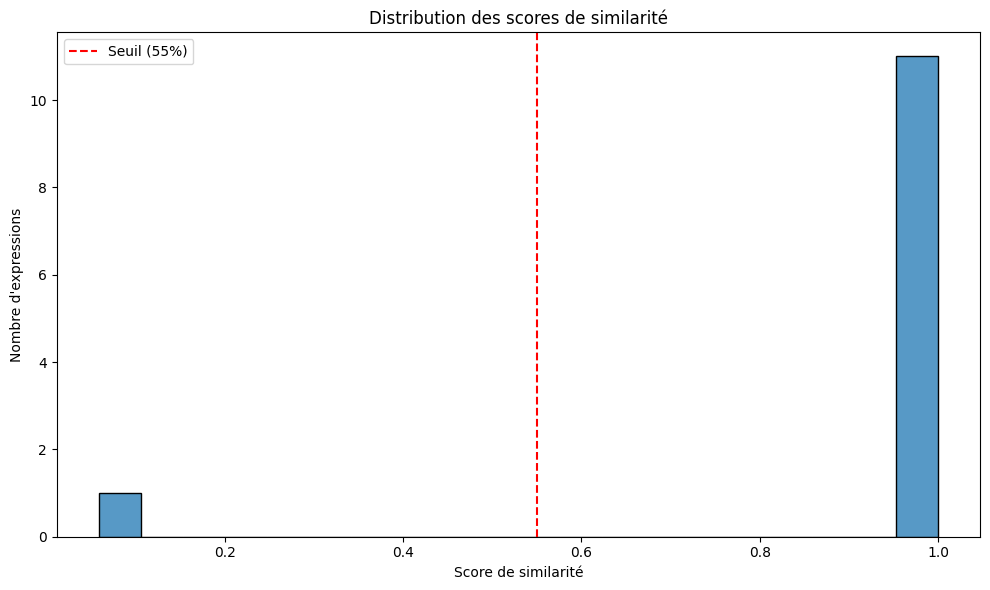

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

TEST_RESULTS_PATH = "testResults/GRATUITE_S_PP/"

def setup_test_dir():
    """Crée le répertoire de résultats"""
    os.makedirs(TEST_RESULTS_PATH, exist_ok=True)

def process_test_case(test, context, examples, similarity_threshold):
    """
    Traite un cas de test unique

    Args:
        test: Le cas de test à traiter
        context: Le contexte disponible
        examples: Les exemples d'expressions
        similarity_threshold: Seuil de similarité

    Returns:
        dict: Résultat du test
    """
    # Génération et mesure du temps
    start_time = time.time()
    try:
        generated = generate_expression(
            test['query'],
            available_context=context,
            examples=examples
        )
    except Exception as e:
        print(f"Erreur: {str(e)[:100]}...")
        generated = "Erreur API"

    execution_time = time.time() - start_time

    if not generated or generated.strip() == "":
      return None  # Retourner None au lieu d'un résultat

    # Calcul des métriques
    similarity = calculate_similarity(test['expected'], generated)
    is_match = similarity >= similarity_threshold

    # Construction du résultat
    return {
        'query': test['query'],
        'expected': test['expected'],
        'generated': generated,
        'similarity': similarity,
        'is_match': is_match,
        'execution_time': execution_time
    }

def write_result_to_file(f, result):
    """
    Écrit un résultat dans un fichier

    Args:
        f: Le fichier ouvert en écriture
        result: Le résultat à écrire
    """
    f.write(f"Query: {result['query']}\n")
    f.write(f"Expected: {result['expected']}\n")
    f.write(f"Generated: {result['generated']}\n")
    f.write(f"Similarité: {result['similarity']:.2%}\n")
    f.write(f"Résultat: {'✅ Match' if result['is_match'] else '❌ No Match'}\n\n")

def calculate_epoch_metrics(epoch_results):
    """
    Calcule les métriques pour une époque

    Args:
        epoch_results: Les résultats de l'époque

    Returns:
        float: Le taux de correspondance
    """
    epoch_df = pd.DataFrame(epoch_results)
    return epoch_df['is_match'].mean() if not epoch_df.empty else 0

def generate_visualizations(all_results, epoch_times, similarity_threshold, epochs):
    """
    Génère les visualisations des résultats

    Args:
        all_results: Tous les résultats de test
        epoch_times: Temps d'exécution par époque
        similarity_threshold: Seuil de similarité
        epochs: Nombre d'époques
    """
    all_df = pd.DataFrame(all_results)

    # 1. Graphique de distribution des similarités
    plt.figure(figsize=(10, 6))
    sns.histplot(data=all_df, x='similarity', bins=20)
    plt.axvline(x=similarity_threshold, color='red', linestyle='--',
                label=f'Seuil ({similarity_threshold:.0%})')
    plt.title('Distribution des scores de similarité')
    plt.xlabel('Score de similarité')
    plt.ylabel("Nombre d'expressions")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{TEST_RESULTS_PATH}distribution_similarite.png")

def calculate_average_results(query_results):
    """
    Calcule les résultats moyens par requête

    Args:
        query_results: Dictionnaire des résultats par requête

    Returns:
        DataFrame: Résultats moyens
    """
    avg_results = []

    for query, results in query_results.items():
        # Trouver le meilleur résultat
        best_result = max(results, key=lambda x: x['similarity'])

        # Calculer les moyennes
        similarities = [r['similarity'] for r in results]
        is_matches = [r['is_match'] for r in results]

        avg_results.append({
            'query': query,
            'expected': best_result['expected'],
            'best_generated': best_result['generated'],
            'avg_similarity': np.mean(similarities),
            'match_rate': np.mean(is_matches)
        })

    return pd.DataFrame(avg_results)

def run_tests(context, examples, similarity_threshold=0.55, epochs=5):
    setup_test_dir()

    all_results = []
    epoch_times = []
    start_total = time.time()

    query_results = {}

    for epoch in range(1, epochs + 1):
        print(f"Époque {epoch}/{epochs}...")
        start_epoch = time.time()

        epoch_results = []
        with open(f"{TEST_RESULTS_PATH}resultats_epoch_{epoch}.txt", "w", encoding="utf-8") as f:
            for test in test_cases:
                user_query = test['query']

                # Contexte et exemples filtrés dynamiquement
                filtred_examples = {v: k for k, v in examples.items()}
                filtred_context = {v: k for k, v in context.items()}

                result = process_test_case(
                    test, filtred_context, filtred_examples, similarity_threshold
                )

                if result is None:
                    continue

                query = test['query']
                if query not in query_results:
                    query_results[query] = []
                query_results[query].append(result)

                all_results.append(result)
                epoch_results.append(result)

                write_result_to_file(f, result)

        duration = time.time() - start_epoch
        epoch_times.append(duration)

        match_rate = calculate_epoch_metrics(epoch_results)
        print(f"Précision: {match_rate:.2%}")
        print(f"Époque terminée en {duration:.2f}s\n")

    total_time = time.time() - start_total
    print(f"Temps total: {total_time:.2f}s")

    avg_df = calculate_average_results(query_results)
    avg_df.to_csv(f"{TEST_RESULTS_PATH}resultats_moyens.csv", index=False)

    print(f"Taux de correspondance moyen: {avg_df['match_rate'].mean():.2%}")
    print(f"Similarité moyenne: {avg_df['avg_similarity'].mean():.2%}")

    generate_visualizations(all_results, epoch_times, similarity_threshold, epochs)

    return avg_df

# Utilisation
test_cases = read_file('test_data/test_cases.json')
run_tests(AVAILABLE_CONTEXT, SYMFONY_EXAMPLES, epochs=1)